# Cooking ingredients recommendation
This notebook builds a recommendation system for cooking ingredients using. The end goal is to build a recommendation system that takes as input a list of existing ingredients and outputs a collection of ingredients that would go well with the existing ingredients. 

<b> Notebook contents </b>
0. load and clean data
1. Collaborative filtering
2. Word-embeddings
3. Neural network 
4. Association rule mining   
* Future directions / To Do 

***NOTE:*** *This is project is in progress.*



In [2]:
import pandas as pd
import numpy as np
import re
import random
import ijson
import ast 
import csv
import statistics
from itertools import combinations


from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from collections import Counter 
 
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

import os
import pickle
import h5py
import gensim
from gensim.models import Word2Vec

from efficient_apriori import apriori

# 0. Load & clean data    

* While I found some sources for recipe data, I chose to work with the <a href="https://www.kaggle.com/kaggle/recipe-ingredients-dataset/">recipe-ingredients dataset</a> from Kaggle.  
* The dataset was provided as part of a competition for predicting the cuisine type given ingredients list. 
* I chose this dataset because I wanted to ask my recommender system questions like "How do I cook my chicken in Indian style? Korean style?  
* In particular, I used just the training data of this dataset. 
* If one was interested in building a recommender system for ingredients without considering the cuisine, one could use both the training and testing set of the Kaggle dataset. One can also extend the dataset by combining with other sources of recipe data  
* For example, the "recipes" notebook uses a different dataset. Note that that particular dataset requires more involved text cleaning process than the kaggle dataset

<b> Contents </b>  
(a) Load data  
(b) Text cleanup   
(c) Preliminary analysis    
(d) Split data into training, cross-validation, and testing set  
(e) Define metrics for evaluating different models  


<b> (a) Load data </b>

In [10]:
file_name = 'data/recipe-ingredients-dataset/train.json'

with open(file_name, 'r') as f:
  objects = ijson.items(f, 'item')
  data = list(objects)

df = pd.DataFrame(data)

<b> (b) Clean up text </b>  
* Some issues with the given data:  
    (1) Some ingredients contain additional information given in parentheses. Example: " (2 oz. ) tomato sauce "  
    (2) Some ingredients have upper case letters, while most ingredients are written in lower case letters.  
    (3) Some ingredients contain brand names of the ingredients.  
    (4) Some ingredients contain non-alphabet characters. Many of them seem to come from brand names.   
    (5) Some ingredients contain additional instructions. Example: "spinach, thawed and squeezed dry"  
    
* In this section, I addressed issues (1) and (2) by <b> removing any characters between parentheses, and turning all strings into lowercase letters. </b>      
* I did not address issue (3) because removing brand names would be consuming process with little reward, given there aren't many ingredients containing brand names. One way to do this is to manually go through all ingredients that contain Upper case letters, determine whether they refer to generic ingredients or brand names, and remove brand names accordingly. Note: one would have to complete this step before addressing issue (2).  
* Usually, I would remove non-alphabet characters for NLP tasks. However, since we are not doing any word/ character generation and non-alphabet characters seem to be associated with brand names, I decided that removing the non-alphabet characters wouldn't make much difference. 
* Addressing issue (5) would involve manually going through the data

In [12]:
# let's take a look at the list of ingredients to figure out
# what kind of text cleaning is required

ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')

print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:20])
print(ing_list[-20:])

Example ingredients
['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham']
['yolk' 'yoplait' 'young coconut meat' 'young leeks' 'young nettle'
 'yu choy' 'yuca' 'yucca' 'yucca root' 'yukon gold' 'yukon gold potatoes'
 'yuzu' 'yuzu juice' "za'atar" 'zest' 'zesty italian dressing' 'zinfandel'
 'ziti' 'zucchini' 'zucchini blossoms']


In [13]:
# Remove characters between (and including) parentheses
# Turn all strings into lowercase  
# replace spaces with underscore. 

for i in df.index:
    ing = df.at[i,'ingredients']
    for j, item in enumerate(ing):
        
        # Replace all characters between parentheses
        if  ('(' in item) or (')' in item):
            item = re.sub('\s*\([^)]*\)\s*', '', item)
            ing[j] = item
        
        # Turn all Upper case into lowercase
        ing[j] = item.lower()
        
        # replace spaces with underscore 
        ing[j] = ing[j].replace(' ','_')
        
    df.at[i,'ingredients'] = ing

In [14]:
ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')
  
print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:20])
print(ing_list[-20:])

Example ingredients
['1%_low-fat_buttermilk' '1%_low-fat_chocolate_milk'
 '1%_low-fat_cottage_cheese' '1%_low-fat_milk' '2%_low-fat_cottage_cheese'
 '2%_low_fat_cheddar_chees' '2%_lowfat_greek_yogurt'
 '2%_milk_shredded_mozzarella_cheese' '2%_reduced-fat_milk'
 '25%_less_sodium_chicken_broth'
 '2_1/2_to_3_lb._chicken,_cut_into_serving_pieces'
 '33%_less_sodium_cooked_deli_ham' '33%_less_sodium_cooked_ham'
 '33%_less_sodium_ham' '33%_less_sodium_smoked_fully_cooked_ham'
 '40%_less_sodium_taco_seasoning' '40%_less_sodium_taco_seasoning_mix'
 '7_up' '8_ounc_ziti_pasta,_cook_and_drain' '95%_lean_ground_beef']
['young_leeks' 'young_nettle' 'yu_choy' 'yuca' 'yucca' 'yucca_root'
 'yukon_gold' 'yukon_gold_potatoes' 'yuzu' 'yuzu_juice' 'yuzukosho'
 "za'atar" 'zatarains_creole_seasoning' 'zatarainâ€™s_jambalaya_mix'
 'zest' 'zesty_italian_dressing' 'zinfandel' 'ziti' 'zucchini'
 'zucchini_blossoms']


In [15]:
# add cleaned up ingredients + cuisine to dataframe
df['ing_cuisine'] = ingredients
df.to_csv('data/ingredient_recommendation/data.csv')

In [16]:
df.head()

,id,cuisine,ingredients,ing_cuisine
0,10259,greek,"[romaine_lettuce, black_olives, grape_tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,25693,southern_us,"[plain_flour, ground_pepper, salt, tomatoes, g...","[plain_flour, ground_pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking_oil, g...","[eggs, pepper, salt, mayonaise, cooking_oil, g..."
3,22213,indian,"[water, vegetable_oil, wheat, salt]","[water, vegetable_oil, wheat, salt, indian]"
4,13162,indian,"[black_pepper, shallots, cornflour, cayenne_pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


In [25]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]

# change data format to list of tuples for apriori algorithm 
ing_list = [tuple(item) for item in ingredients]

<b> (c) Preliminary analysis </b>  

* About 40,000 recipes involving 6700 ingredients  
* Note that some cuisine (like Italian and Mexican cuisine) are more frequently represented than some others (like Russian and brazilian cuisinze).  
    * I should keep in mind <b>the potential bias</b> this creates: Our recommendation system might recommend ingredients that go well together in mostly Italian and Mexican cuisine. 
    *  <b><font color='red'>To Do</font></b>: I might want to consider some tools for decreasing bias from my model. 

In [18]:
ing_list = np.unique([item for recipes in ingredients for item in recipes])

print('total number of recipes: ', len(ingredients))
print('total number of ingredients: ', len(np.unique(ing_list)))

total number of recipes:  39774
total number of ingredients:  6713


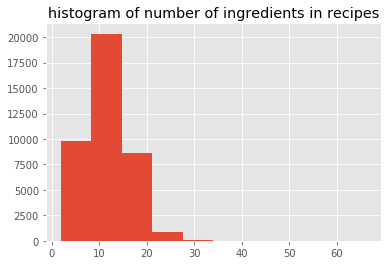

maximum number of ingredients in a given recipe:  66
minimum number of ingredients in a given recipe:  2


In [19]:
# Number of ingredients in each recipe
ing_len = [len(x) for x in ingredients]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

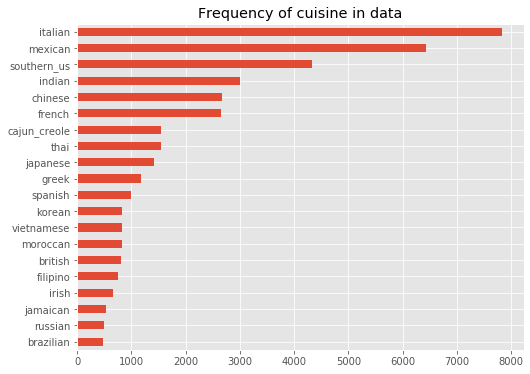

In [26]:
# Number of cuisine represented
cuisine_count = {}
for item in cuisine:
    cuisine_count[item] = cuisine.count(item)

df['cuisine'].value_counts(ascending = True).plot(kind = 'barh', figsize=(8,6))
plt.title('Frequency of cuisine in data')
plt.show()

<b> (d) Divide into training, cross-validation, and testing set </b>

In [27]:
# Divide into training (70%), cross-validation (15%), and testing set (15%)
n_recipes = df.shape[0]
print('total number of recipes: ', n_recipes)

total = list(range(n_recipes))
random.shuffle(total)

train_size = int(n_recipes * 0.7)
cv_size = int(n_recipes * 0.15)
train_idx = total[:train_size]
cv_idx = total[train_size:train_size + cv_size]
test_idx = total[train_size + cv_size:]

print('number of training set: ', len(train_idx))
print('number of cross-validation set: ', len(cv_idx))
print('number of test set: ', len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'w')
f.create_dataset("train_idx", data = train_idx)
f.create_dataset("cv_idx", data = cv_idx)
f.create_dataset("test_idx", data = test_idx)
f.close()

# to load
#f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
#train_idx = list(f.get("train_idx"))
#cv_idx = list(f.get("cv_idx"))
#test_idx = list(f.get("test_idx"))
#f.close()

total number of recipes:  39774
number of training set:  27841
number of cross-validation set:  5966
number of test set:  5967


<b> (e) Define metric for evaluating different models</b>  
* Use evaluation metric for classification models      
* Precision, Recall, and F-scores 
    * Precision: Of all the predicted ingredients, how much were actually true ingredients? TP / (TP + FP)
    * Recall: Of all the true ingredients, how much did we predict correctly? TP/(TP + FN)   
    * F-score : (2 * recall * precision) / (recall + precision)    
    
* Possible option: Weigh the incorrect ingredients. For example, if an incorrect predicted ingredient is still considered "similar" to an existing ingredient (maybe using word embedding features), one can still account for the incorrect prediction as a true positive with a smaller weight than 1
  

In [329]:
def compute_scores(predicted_ing, true_ing):
    """
    predicted_ing: (list) of predicted ingredients from the model
    true_ing: (list) of true ingredients that needed to be predicted
    """
    
    predicted_ing = set(predicted_ing)
    true_ing = set(true_ing)

    TP = len(predicted_ing.intersection(true_ing))

    precision = TP / (len(predicted_ing))
    recall = TP / len(true_ing)
    
    if recall != 0 and precision != 0:
        F_score = (2 * recall * precision)/(precision + recall)
    else:
        F_score = 0
    
    return precision, recall, F_score


In [326]:
# example 
precision, recall, F_score = compute_scores(['onions', 'scallions', 'bread'],
                                           ['scallions'])

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5


# 1. Collaborative filtering  


<b> Summary </b> 
* Used non-negative matrix factorization.  
* Latent variables (roughly) correspond to type of cuisine, such as baking, Italin food, Mexican food, ... .  
* Built a recommendation system from the matrix factorization.  
* Solution to cold-start problem: Found recipes that are most similar to given list of ingredients. Returned ingredients recommended to these similar recipes.  

<b> To do </b> 
* Cross validation to choose the number of latent factors: It turns out, there is a way to do some form of cross-validation with unsupervised learning models, as shown in this <a href="http://alexhwilliams.info/itsneuronalblog/">blog post</a>   

<b> The idea behind non-negative matrix factorization (NMF) </b>
* Given a matrix V, NMF factorizes V into non-negative matrices W and H such that $ W H \approx V$. 
![From wikipedia](files/images/NMF.png)  


* One can describe each column of V as a linear combination of columns of W. The coefficients of this linear combination is given by the columns of H. 

* Idea: The factorization $ W H \approx V$ learns latent features underlying the interactions beetween recipes and ingredients.

* In this project, consider V as the ingredients-recipe matrix. 
    * Each column of V corresponds to a recipe.  
    * Each row of V corresponds to an ingredient.  
    * V [ i ][ j ] = 1 if ingredient *i* is present in recipe *j*, and 0 otherwise
* Non-negative matrix factorization will attempt to find matrices W and H such that  
$W H \approx V$


<b> Create matrix V </b>  
* columns: recipes  
* rows: ingredients  
* V [ i ][ j ] = 1 if ingredient *i* is present in recipe *j*, and 0 otherwise

In [30]:
# Find all the ingredients
ingredients_total = [item for sublist in ingredients for item in sublist]
ingredients_total = list(set(ingredients_total))

n_ingredients = len(ingredients_total)
n_recipes = len(ingredients)

print('number of ingredients: ', n_ingredients)
print('number of recipes: ', n_recipes)

# Assign row values to each ingredient
ing_dict = {idx:x for idx, x in enumerate(ingredients_total)}
ing_dict_reverse = {value:key for key, value in ing_dict.items()}

# create matrix V
V = np.zeros((n_ingredients, n_recipes))
for i, recipe in enumerate(ingredients):
    for ing in recipe:
        j = ing_dict_reverse[ing]
        V[j,i] = 1

number of ingredients:  6734
number of recipes:  39774


<b> Latent variables </b>  
For fun, let's see what the latent variables represent when we do a matrix factorization with 10 latent variables 

In [ ]:
model = NMF(n_components=10)
W = model.fit_transform(V)
H = model.components_

In [142]:
# For each component return 10 most representative ingredients
for i in range(10):
    indices = np.argsort(W[:,i])[::-1][:10]
    print('***LATENT COMPONENT ' + str(i) + '***')
    for item in indices:
        print(ing_dict[item])

***LATENT COMPONENT 0***
salt
pepper
black pepper
eggs
flour
garlic powder
lemon juice
oil
greek
cooking spray
***LATENT COMPONENT 1***
all-purpose flour
southern_us
butter
sugar
large eggs
baking powder
unsalted butter
milk
eggs
vanilla extract
***LATENT COMPONENT 2***
italian
olive oil
grated parmesan cheese
fresh basil
dry white wine
dried oregano
fresh parsley
flat leaf parsley
extra-virgin olive oil
tomatoes
***LATENT COMPONENT 3***
soy sauce
chinese
sugar
sesame oil
green onions
corn starch
garlic
vegetable oil
scallions
rice vinegar
***LATENT COMPONENT 4***
mexican
ground cumin
chili powder
sour cream
jalapeno chilies
avocado
corn tortillas
salsa
chopped cilantro fresh
black beans
***LATENT COMPONENT 5***
garlic cloves
extra-virgin olive oil
olive oil
onions
cooking spray
fresh lemon juice
red bell pepper
chopped onion
black pepper
carrots
***LATENT COMPONENT 6***
onions
garlic
carrots
olive oil
pepper
green bell pepper
cajun_creole
celery
chicken broth
tomatoes
***LATENT COMPON

Indeed, the latent variables correspond to different types of cuisine.    
For example, latent variable 1 represents ingredients used for baking.  
Latent variable 2 represents ingredients used for Italian food.  
Latent variable 3 represents ingredients used for Chinese food.  
Latent variable 4 represents ingredients used for Mexican food.  

<b> Perform NMF</b>  

In [144]:
model = NMF(n_components=300)
W = model.fit_transform(V)
H = model.components_

#print(model.reconstruction_err_)

In [158]:
f = h5py.File("models/NMF/NMF_300.hdf5", "w")
f.create_dataset('V', data = V)
f.create_dataset('W', data = W)
f.create_dataset('H', data = H)
f.close()

<b> Perform recommendation </b>  
* One of the problems with collaborative filtering is the cold-start problem.  
* In this project, the most relevant cold-start problem is when a new user is added.  When a new user comes with a few existing ingredients and ask for recommendations, there are two problems to address:   
    (1) How to provide a recommendation to the user?   
    (2) How to update the matrix factorization, without having to redo the entire factorization all over again?  
    
In this section, I'm mostly concerned with problem (1). There are some active research going on regarding online updating of matrix factorizations to address problem (2).   

While there are multiple tactics for addressing new user problems, I chose to find other users/ recipes that are similar to the new user. I then used the factorized matrices to recommend ingredients 

<b> Recommendation to an existing recipe </b>

In [167]:
f = h5py.File('models/NMF/NMF_300.hdf5', 'r')
V = np.array(f.get('V'))
W = np.array(f.get('W'))
H = np.array(f.get('H'))
f.close()

V_approx =np.matmul(W,H)

In [168]:
# Let's compare the recommendations to existing recipes 
recipe_num = 20

print("*** EXISTING INGREDIENTS ***")
for item in ingredients[recipe_num]:
    print(item)
    
# print the top 20 recommended ingredients

print("*** RECOMMENDED INGREDIENTS ***")
recommend = np.argsort(V_approx[:,recipe_num])[::-1]
for item in recommend[:20]:
    print(ing_dict[item])

*** EXISTING INGREDIENTS ***
pork loin
roasted peanuts
chopped cilantro fresh
hoisin sauce
creamy peanut butter
chopped fresh mint
thai basil
rice
medium shrimp
water
rice noodles
beansprouts
thai
*** RECOMMENDED INGREDIENTS ***
thai
water
chopped cilantro fresh
rice
medium shrimp
beansprouts
chopped fresh mint
hoisin sauce
peanuts
rice noodles
chinese five-spice powder
lemongrass
roasted peanuts
unsweetened coconut milk
rice vermicelli
Thai fish sauce
Thai red curry paste
ground lamb
creamy peanut butter
english cucumber


<b> Recommendation to a new user </b>  

For example, let's say a new user joins. The new user knows that he wants to cook some Korean style chicken, and he knows he wants to use chicken, sesame seeds, and scallions. 


In [169]:
# new user with existing ingredients and preferred cuisine style
user_ing = ['korean', 'chicken', 'sesame seeds', 'scallions']

# define new user vector
new_user = np.zeros((n_ingredients,1))
for item in user_ing:
    idx = ing_dict_reverse[item]
    new_user[idx, 0] = 1

Compute cosine similarity between new user vector and all recipes

In [170]:
# compute dot product between new user and recipes
sim = np.matmul(V.T, new_user)

# compute magnitude of each recipe vector and new user vector
norm_recipes = np.sqrt(np.sum(np.square(V), axis = 0))
norm_user = np.sqrt(np.sum(np.square(new_user)))

# find the normalizing factor for each recipe
norm = np.reciprocal((norm_recipes * norm_user).reshape(-1,1))

# compute cosine similarity
cosine_similarity = np.multiply(sim, norm).flatten()

* Find 10 most similar recipes. 
* Collect 10 recommended ingredients for each recipes. 
* From the collection of recommended ingredients, return ingredients from most frequently recommended to least frequently recommended

In [171]:
# sort based on similarity score 
sim_sort = np.argsort(cosine_similarity)

# Find recommended ingredients
recommend = [] 

# Find 10 most similar recipes
for item in sim_sort[-10:]:
    rec = np.argsort(V_approx[:,item])
    
    # Find 10 ingredients to recommend
    for i in rec[-10:]:
        recommend.append(ing_dict[i])

In [172]:
# sort the recommended ingredients according to frequency of recommendation
sorted_rec = sorted(recommend ,key=recommend.count, reverse = True)
rec = [] 

for item in sorted_rec:
    if (item not in rec) and (item not in user_ing):
        rec.append(item)

# print 10 ingredients to recommend
print("Recommended ingredients: ")
for i in range(10):
    print(rec[i])
        


Recommended ingredients: 
Gochujang base
kimchi
soy sauce
sesame oil
rice wine
vegetable oil
garlic cloves
water
napa cabbage
chopped garlic


# 2. Word embeddings  

(a) Word2Vec   
(b) GloVe  

<b> Why word embeddings? </b>  
I thought that the word analogies of word embeddings would be useful in understanding questions like "what vegetable would go well with lamb?". I was also inspired by other data scientists who used word embeddings for context-dependent recommenders. (Examples: <a href="https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484">music recommendation</a>, <a href="https://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/">stitch fix</a>, <a href="https://www.nature.com/articles/s41586-019-1335-8">material science</a>, and <a href="http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/"> many others </a>)

I investigated two possibilities with word embeddings. 
 
1. Can word analogies be useful in understanding questions like "what vegetable would go well with lamb?"  
2. What is the relationship between ingredients that have similar vector representations? Are they substitutes? complementary? Depending on the answer to this question, I can then attempt to build a recommendation system from word embeddings

In this section, I investigate the above two questions for Word2Vec and GloVe embeddings.  
* I started with Word2Vec because more familiar with the model.  
* However, for this particular project, I realized that GloVe may be better suited for this project.

Some explanation for why I studied GloVe as well:

Note that Word2Vec extracts embeddings from a neural network designed to perform a surrogate task. In the continuous-bag-of-words (CBOW) model, the surrogate tasks is to predict a word given the surrounding context words. The size of this context can be defined by the user. I wanted to remove this dependence on the size of the context because of the following reason:

Say we have a recipe with 10 ingredients:[i0, i1, i2, ... , i9] 
If we chose a context size of 2 words to the left and right, then the surrogate task would attemt to solve the following task:
    * From ingredients (i0, i1, i3, i4), predict i2
    * From ingredients (i1, i2, i4, i5), predict i3, and so on.
Thus, according to the model, ingredient i9 does not appear in the context of i0. However, we do want all ingredients belonging to the same recipe to be considered as being in the same context.  

There are ways to work around this. (1) We can permute the order of ingredients in each recipe, and hope that we have a large enough training set. (2) We could also add to the training set some different permutations of the ingredients. (3) We could use GloVe.

GloVe learns word embeddings based on the co-occurrence count of words. In this case, any two ingredients that appear together in the same recipe will be considered as co-occuring words. 


<b> Summary </b>
* Given a word, the most similar words are sometimes
    * substitutes and similar ingredients
    * complementary ingredients
* For example, when we ask for the closest ingredient to "chicken" (using the GloVe model), we get: garlic, onions, chicken stock, chicken broth, chicken breasts, sauce, pepper, .... 
    * While garlic and onions are considered good complementary ingredients, ingredients like chicken stock, chicken broth, chicken breasts similar items that we do not necessarily need. 
* We only want "complementary ingredients". 



## 2(a) word embeddings: word2vec  

I played around with three different kinds of word2vec models:  
i) Pre-trained Word2Vec model    
ii) A Worc2Vec model trained on our data

I went through the three models for the following reasons: 
* I started with the pre-trained Word2Vec model from the Google News dataset. 
* While the pre-trained model has the advantage of easy use, it takes a long time to load the model and to query the embedding, probably because the model contains 3 millioin words and phrases.   
* Furthermore, some queries resulted in words that are irrelevant to cooking. 
* For this project, I decided that training a Word2Vec model on just cooking-related terms would be (1) faster to use and (2) more relevant to our project.  
 
 
* I then decided to train a Word2Vec model using recipe directions. 
* The resulting model was much faster to query than the pre-trained model, and the results were more cooking-specific.  

###  2(a) i) pre-trained word2vec model

* pre-trained word2vec model from the <a href="https://code.google.com/archive/p/word2vec/">Google News dataset</a>
* The model contains 300-dimensional vectors for 3 million words and phrases  
* You should download the pre-trained model in the <a href="https://code.google.com/archive/p/word2vec/">Google Code Archive</a>

In [7]:
# load pre-trained word2vec model
path_googlenews = 'models/word2vec/GoogleNews-vectors-negative300.bin'
pretrained_word2vec= gensim.models.KeyedVectors.load_word2vec_format(path_googlenews, binary=True) 

In [5]:
pretrained_word2vec.similar_by_word('steak',topn=15,restrict_vocab=None)

[('steaks', 0.7992713451385498),
 ('filet_mignon', 0.7782121896743774),
 ('porterhouse', 0.7527751922607422),
 ('sirloin', 0.7395126819610596),
 ('prime_rib', 0.7364764213562012),
 ('filet', 0.7349370718002319),
 ('porterhouse_steak', 0.7305288314819336),
 ('tenderloin', 0.7280069589614868),
 ('roast_beef', 0.7186790108680725),
 ('rib_eye', 0.7158585786819458),
 ('ribeye_steak', 0.7071082592010498),
 ('sirloin_steak', 0.7050917744636536),
 ('ribeye', 0.701675295829773),
 ('hanger_steak', 0.6981855630874634),
 ('striploin', 0.6928503513336182)]

### 2(a) iii) Train a word2vec model

In [3]:
# train word2vec
embedding_dim=300
model=gensim.models.Word2Vec(ingredients, size=embedding_dim, window=30, min_count=0)

In [4]:
model.wv.most_similar('steak',topn=15,restrict_vocab=None)

[('pork chops', 0.9173249006271362),
 ('chili pepper flakes', 0.9021896123886108),
 ('soup', 0.8890161514282227),
 ('shrimp shells', 0.8835002779960632),
 ("Frank'sÂ® RedHotÂ® Original Cayenne Pepper Sauce", 0.8797524571418762),
 ('mixed vegetables', 0.8683021068572998),
 ('sauce', 0.86557537317276),
 ('fish balls', 0.8647212982177734),
 ("tony chachere's seasoning", 0.8566193580627441),
 ('cabbage leaves', 0.8564741611480713),
 ('frozen broccoli florets', 0.8563554286956787),
 ('kinchay', 0.8525336980819702),
 ('buns', 0.8517208695411682),
 ('boneless chicken breast', 0.8515726923942566),
 ('chuno sauce', 0.8510098457336426)]

In [24]:
model.wv.most_similar('chicken', topn = 15)

[('basmati', 0.8501617908477783),
 ('homemade stock', 0.8499741554260254),
 ('red kidney beans', 0.8388198614120483),
 ('spices', 0.8258204460144043),
 ('rice', 0.8199082016944885),
 ('hot pepper', 0.8172221183776855),
 ('pork shoulder', 0.8009617328643799),
 ('imitation seafood', 0.8001091480255127),
 ('chicken thighs', 0.7935663461685181),
 ('bay leaves', 0.7888513207435608),
 ('meat', 0.7874410152435303),
 ('chicken stock', 0.7855333089828491),
 ('sablefish', 0.7811201810836792),
 ('bell pepper', 0.778683066368103),
 ('chuck', 0.7778372764587402)]

<b> Word analogies </b> 
* Let's say I'm cooking lamb, and I want to know what vegetable would go well with lamb. 
* I can use known protein-vegetable pairings, such as steak & asparagus, to ask the word embedding to solve the following word analogy problem  
    <b>steak</b> is to <b>asparagus</b> as <b>lamb</b> is to <b>?</b>   
    i.e., steak : asparagus = lamb : ?  
* That is, we want to find the ingredient that best satisfies the following:  
    wv['asparagus']-wv['steak'] = wv[?] - wv['lamb'], or
    wv[?] = wv['lamb'] + wv['asparagus'] - wv['steak']
    

In [23]:
model.wv.similar_by_vector(model.wv['lamb']+model.wv['asparagus']-model.wv['steak'],restrict_vocab=None)

[('yellow crookneck squash', 0.9291372299194336),
 ('fennel bulb', 0.9225113391876221),
 ('fennel', 0.9141095876693726),
 ('nonfat chicken broth', 0.8998813033103943),
 ('asparagus', 0.8944079875946045),
 ('Italian parsley leaves', 0.8843654990196228),
 ('florets', 0.873955488204956),
 ('striped bass', 0.8687739968299866),
 ('fresh rosemary', 0.8651928901672363),
 ('hot red pepper flakes', 0.8642042875289917)]

<b> Cooking in style </b>  
* What if I wanted to cook a particular ingredient in a particular cuisine?  
* For example, if I wished to cook chicken in an Indian style cuisine, what other ingredients would go well?

In [27]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['indian'],topn=15)


[('indian', 0.9673752784729004),
 ('garam masala', 0.927364706993103),
 ('ground turmeric', 0.9177412986755371),
 ('tumeric', 0.9012154340744019),
 ('cumin seed', 0.8709600567817688),
 ('basmati rice', 0.8704847097396851),
 ('mild curry powder', 0.8595356941223145),
 ('calabash', 0.856178343296051),
 ('ground tumeric', 0.8478215932846069),
 ('yoghurt', 0.8407273292541504),
 ('curry leaves', 0.8394922614097595),
 ('fenugreek', 0.839362621307373),
 ('mustard seeds', 0.835870087146759),
 ('yellow split peas', 0.833548903465271),
 ('black mustard seeds', 0.8307055830955505)]

<b>Recommending new ingredients from existing ingredients </b>  
* For example, let's say I want to cook my chicken in Korean style, and I have the following ingredients: chicken, onions, sesame seeds.  
* Can the model recommend some other ingredients that would go well?  

In [28]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['korean']
                           + model.wv['onions'] + model.wv['sesame seeds'],topn=15)

[('other vegetables', 0.8722476363182068),
 ('Gochujang base', 0.8670608997344971),
 ('sesame oil', 0.854427695274353),
 ('rice wine', 0.8444992899894714),
 ('Korean chile flakes', 0.8362123966217041),
 ('bean sauce', 0.8357012271881104),
 ('ramen noodles', 0.8195841312408447),
 ('marinade', 0.8191328048706055),
 ('soybean paste', 0.8187799453735352),
 ('bean paste', 0.818573534488678),
 ('gochugaru', 0.816921055316925),
 ('kimchi', 0.814910888671875),
 ('korean', 0.811623215675354),
 ('toasted sesame seeds', 0.8076875805854797),
 ('fried eggs', 0.8049585819244385)]

* 'Other vegetables' is good for our diet but really not helpful right now..  
* The other recommendations do seem helpful and in line with Korean style cuisine


## 2(b) word embeddings using GloVe  

* Similar to word2vec, but based on a co-occurence statistics  
* Had to use these on my mac  
* Note: training GloVe isn't done in this notebook
* This section simply prepares the text for training and analyzes the result 
* Does GloVe depend on how close the words are? Or is it just about co-occurrence in the same document? 

In [29]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

<b> Prepare text for training GloVe</b> 
* According to <a href="https://github.com/stanfordnlp/GloVe/tree/master/src">GloVe README file</a>, we should prepare our text file according to the following. 
    * Prepare corpus as a single text file
    * Words should  be separated by one or more spaces or tabs
    * Multiple documents should be separated by new line characters. Cooccurrence contexts for words do not extend past newline characters

In [5]:
# print current format
print(ing_cuisine[:10])

[['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles', 'greek'], ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil', 'southern_us'], ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers', 'filipino'], ['water', 'vegetable oil', 'wheat', 'salt', 'indian'], ['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'butter', 'salt', 'lemon juice', 'water', 'chili powder', 'passata', 'oil', 'ground cumin', 'boneless chicken skinless thigh', 'garam masala', 'double cream', 'natural yogurt', 'bay leaf', 'indian'], ['plain flour', 'sugar', 'butter', 'eggs', 'fresh ginger root', 'salt', 'ground cinnamon', 'milk', 'vanilla extract', 'ground ginger', 'p

In [21]:
# In Glove, spaces are used to separate words.
# Ingredients that involve spaces should be adjusted

# for each recipe, replace spaces with underscore, and join all ingredients into one string
glove_training = []

for recipe in ing_cuisine:
    # replace spaces in ingredients with underscore
    recipe_new = [item.replace(' ','_') for item in recipe]
    
    # join ingredients into a string and add newline character 
    glove_training.append(' '.join(recipe_new)+'\n')

In [23]:
f = open("model/glove/glove_training.txt", "w")
f.writelines(glove_training)
f.close()

In [28]:
# Double check that we have the correct file format
# the following should give ingredients of the first two cuisine
#f = open('data/glove/glove_training.txt','r')
#print(f.readline())
#print(f.readline())
#f.close()

romaine_lettuce black_olives grape_tomatoes garlic pepper purple_onion seasoning garbanzo_beans feta_cheese_crumbles greek

plain_flour ground_pepper salt tomatoes ground_black_pepper thyme eggs green_tomatoes yellow_corn_meal milk vegetable_oil southern_us



<b> Training on GloVe </b>  
* Clone <a href="https://github.com/stanfordnlp/GloVe">GloVe repository</a> 
* Run "make" 
* Copy the "glove_training.txt" file to the glove directory 
* Edit the "demo.sh" file:
    * Remove the 9 lines after "make" starting with "if" and ending with "fi"  
    * Edit right side of "CORPUS=" with file name "glove_training.txt"  
* Run "./demo.sh" 
* The word vectors will be saved in the "vectors.txt" file. 

<b> GloVe results </b>  
* Vocab size: 3357
* Vector size: 50
* Cost: 0.0325



In [ ]:
# Note: GloVe returns the statistics of co-occurrence and the word embeddings
# it doesn't return a model like word2vec that can be used to predict surrounding words
# Just have to do the best with the embeddings themselves

In [30]:
# convert GloVe vector text format into word2vec text format
# This way, we can use gensim to do word comparisons and analysis
glove2word2vec(glove_input_file="model/glove/glove_vectors.txt", 
               word2vec_output_file="model/glove/gensim_glove_vectors.txt")

/usr/local/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(3358, 50)

In [32]:
glove_model = KeyedVectors.load_word2vec_format("model/glove/gensim_glove_vectors.txt", binary=False)

In [35]:
glove_model.most_similar('steak',topn=15,restrict_vocab=None)

[('cod', 0.6614221930503845),
 ('panko_breadcrumbs', 0.6294422149658203),
 ('pork_chops', 0.5919418334960938),
 ('tonkatsu_sauce', 0.5722765922546387),
 ('beaten_eggs', 0.5602886080741882),
 ('flour', 0.5539854764938354),
 ('frozen_peas_and_carrots', 0.49084463715553284),
 ('min', 0.4804944396018982),
 ('panko', 0.4743003249168396),
 ('chives', 0.4698525071144104),
 ('sweet_chili_sauce', 0.4662887454032898),
 ('ramen_noodles', 0.45906150341033936),
 ('ground_chicken', 0.44420695304870605),
 ('Chinese_rice_vinegar', 0.4360998868942261),
 ('chorizo', 0.43559232354164124)]

In [39]:
glove_model.most_similar('chicken',topn=15,restrict_vocab=None)

[('garlic', 0.7296680808067322),
 ('onions', 0.6966990232467651),
 ('chicken_stock', 0.6510413885116577),
 ('chicken_broth', 0.6387048363685608),
 ('chicken_breasts', 0.626524806022644),
 ('sauce', 0.6245228052139282),
 ('pepper', 0.620618462562561),
 ('yellow_onion', 0.614948570728302),
 ('spices', 0.6102616190910339),
 ('rice', 0.6061379909515381),
 ('bay_leaves', 0.6036665439605713),
 ('cilantro', 0.6028690338134766),
 ('tomatoes', 0.6022893190383911),
 ('kosher_salt', 0.5862119197845459),
 ('bay_leaf', 0.5841464400291443)]

In [37]:
glove_model.similar_by_vector(glove_model['lamb'] + glove_model['asparagus']- glove_model['steak'],topn=15,restrict_vocab=None)


[('couscous', 0.6679390668869019),
 ('asparagus', 0.6486406326293945),
 ('spinach_leaves', 0.6287509799003601),
 ('tahini', 0.62239009141922),
 ('garbanzo_beans', 0.5981909036636353),
 ('fresh_lemon_juice', 0.5812668800354004),
 ('chickpeas', 0.5755916833877563),
 ('pinenuts', 0.5707820653915405),
 ('lemon_zest', 0.5574780702590942),
 ('orzo', 0.5545808672904968),
 ('grated_lemon_peel', 0.5538576245307922),
 ('lamb', 0.5468550324440002),
 ('chopped_fresh_mint', 0.542788565158844),
 ('preserved_lemon', 0.5352820158004761),
 ('arborio_rice', 0.5287206768989563)]

In [38]:
glove_model.similar_by_vector(glove_model['chicken'] + glove_model['korean'],topn=15)

[('korean', 0.8404902219772339),
 ('toasted_sesame_seeds', 0.7193809747695923),
 ('sesame_seeds', 0.713943362236023),
 ('Gochujang_base', 0.7067477703094482),
 ('sesame_oil', 0.702775239944458),
 ('soy_sauce', 0.6895512342453003),
 ('asian_pear', 0.67808997631073),
 ('kimchi', 0.6725336313247681),
 ('beef', 0.6577582955360413),
 ('green_onions', 0.655651330947876),
 ('ginger', 0.642991304397583),
 ('rice_wine', 0.6344742774963379),
 ('sauce', 0.6225952506065369),
 ('chicken', 0.6196356415748596),
 ('noodles', 0.6129593849182129)]

# 3. Continuous-Bag-Of-Words model

* Instead of using the embeddings, let's use the trained model to predict ingredients  
* While you can train a vanila neural network, we'll use the Word2Vec model provided by gensim since it is extremely easy to use  
* I was concerned about the order of the words.
    * The model itself isn't concerned with the order of words appearing in the neighborhood. 
    * A list of ingredients ofr a recipes should be best considered as an unordered set. 
    * However, this means that not all neighbor relations (that should be represented) won't exist

## 3.0 Example

Decide on the appropriate window size

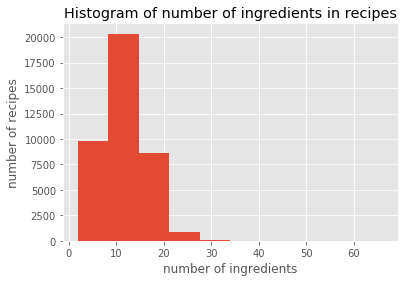

maximum number of ingredients: 66
minimum number of ingredients: 2


In [142]:
# what is the appropriate window size?
ing_length = [len(item) for item in ingredients]
plt.hist(ing_length)
plt.title('Histogram of number of ingredients in recipes')
plt.xlabel('number of ingredients')
plt.ylabel('number of recipes')
plt.show()

print('maximum number of ingredients:', max(ing_length))
print('minimum number of ingredients:', min(ing_length))

In [369]:
# randomly shuffle each ingredient list
for item in ingredients:
    random.shuffle(item)


In [370]:
# train model
# Note: by default, the model will learn a CBOW model
model = Word2Vec(ingredients, window = 5, compute_loss = True, iter = 10)


In [373]:
# get probability distribution of center word given context words
model.predict_output_word(['korean','chicken'], topn = 5)

[('kimchi', 0.0458815),
 ('gochujang_base', 0.04216694),
 ('sesame_seeds', 0.018985698),
 ('toasted_sesame_seeds', 0.0175562),
 ('asian_pear', 0.015904067)]

## 3.1 Model performance on training and cross validation data 

In [388]:
def sample_ingredients(ing, n_samples):  
    # For each recipe, sample "n_samples" number of ingredients randomly.
    # (If a recipe involves fewer than "n_samples" ingredients, ignore that recipe)
    # The sampled ingredients will function as the existing ingredients
    # Goal of the model is to predict the remaining ingredients that
    # have not been sampled
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients 
           for a particular recipe
    n_samples: (int) number of ingredients to be sampled
   
    --- output ---
    sampled_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    remaining_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    """
    
    sampled_ing = []
    remaining_ing = []
    for recipe in ing:
        if len(recipe) > 5:
            # randomly select 5 ingredients
            sampled = random.sample(recipe, 5)
            remain = list(set(recipe)-set(sampled))

            sampled_ing.append(sampled)
            remaining_ing.append(remain)
            
    return sampled_ing, remaining_ing

def recommend_ingredients_word2vec(model, sampled_ing, remaining_ing):
    # predict ingredients using the trained Word2Vec model
    
    # model: trained Word2Vec model
    # sampled_ing: (list of lists) Each item of sampled_ing is a list of
    # existing ingredients for a particular recipe 
    
    predicted_ing = []

    for idx, given_recipe in enumerate(sampled_ing):
        # find number of ingredients to predict
        n = len(sampled_ing[idx]) + len(remaining_ing[idx])  

        # predict ingredients
        prediction = model.predict_output_word(given_recipe, topn = n)
        prediction = [item[0] for item in prediction if item[0] not in given_recipe]
        predicted_ing.append(prediction)
        
    return predicted_ing

In [374]:
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

ing_train = [ingredients[i] for i in train_idx]
ing_cv = [ingredients[i] for i in test_idx]

In [375]:
# train model
model = Word2Vec(ing_train, window = 5, compute_loss = True, iter = 10)
# while the model computes the loss, its a cumulative loss
# (not the loss from the most recent epoch)

<b> Make ingredient recommendations for training data </b> 


In [390]:
# get existing ingredients and the remaining ingredients to be predicted
sampled_ing, remaining_ing = sample_ingredients(ing_train, 5)

# predict remaining ingredients
predicted_ing = recommend_ingredients_word2vec(model, sampled_ing, remaining_ing)

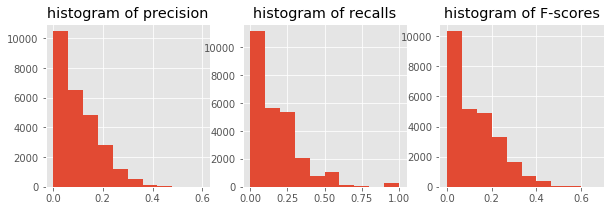

Average precision on cross validation set:  0.09264691577092868
Average recall on cross validation set:  0.1552812082699183
Average F-score on cross validation set:  0.11364571115758526


In [391]:
scores = [compute_scores(predicted_ing[i], remaining_ing[i]) for i in range(len(remaining_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Make ingredient recommendations for CV set </b>

In [378]:
# get existing ingredients and the remaining ingredients to be predicted
sampled_ing, remaining_ing = sample_ingredients(ing_cv, 5)

# predict remaining ingredients
predicted_ing = recommend_ingredients_word2vec(model, sampled_ing, remaining_ing)

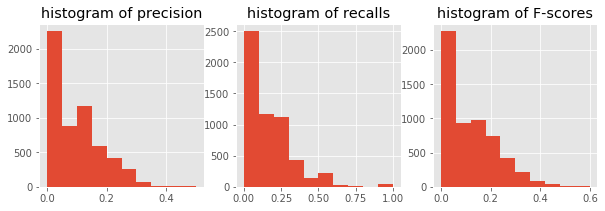

Average precision on cross validation set:  0.08902909831564408
Average recall on cross validation set:  0.1495653688075584
Average F-score on cross validation set:  0.10914539821476701


In [387]:
scores = [compute_scores(predicted_ing[i], remaining_ing[i]) for i in range(len(remaining_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

# 4. Association rule mining

* Association rule mining is a tool used in market basket analysis that seeks relationships between purchases.  
* It finds rules of the form X => Y, which represents "X implies Y"
* For example, the rule {onions, potatoes} => {burger} found in the sales data would indicate that if a customer buys both onions and potatoes, then they are also likely to buy hamburger meat.  
* In this project, I used association rule mining to learn relationships among ingredients. For example, the rule {chicken, korean} => {seasame oil} would imply that if a recipe involves chicken and korean cuisine, then it is likely to also involve seasame oil as its ingredient. 
* Used Apriori algorithm to learn the rules.

## 4.1 Implement the apriori algorithm

* The apriori algorithm learns all rules of form X => Y where
    * X, Y are collections of items, called itemset.  
    * X and Y are itemsets with frequency (support) greater than min_support
    * The strength of the implication X => Y (as measured by confidence) is stronger than min_confidence  
* Apriori algorithm requires the user to specify minimum support of itemsets to consider and minimum confidence of the rules. 
* In this section, I played around with different minimum support and minimum confidence values and learned the rules among ingredients using the apriori algorithm.

In [305]:
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = np.unique(df.cuisine)

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]

# change data format to list of tuples for apriori algorithm 
ing_list = [tuple(item) for item in ingredients]

In [306]:
# get the list of ingredients
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

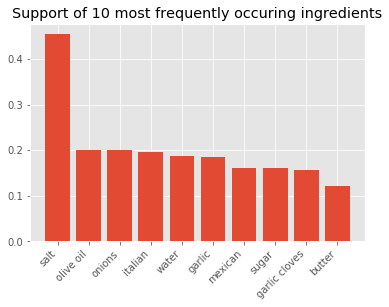

In [307]:
#plot the support of 10 most frequently occurring ingredients
plt.bar(ing_by_count[:10], [ing_count[item]/len(ing_list) for item in ing_by_count[:10]])
plt.xticks(list(range(10)), ing_by_count[:10], ha = 'right', rotation=45)
plt.title('Support of 10 most frequently occuring ingredients')
plt.show()

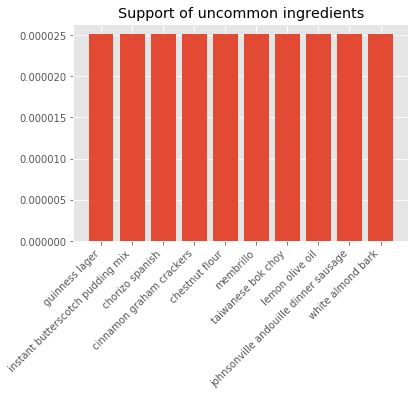

In [308]:
# plot the 10 most rarely occurring ingredients
# use support, instead of frequency 
plt.bar(ing_by_count[-10:], [ing_count[item]/len(ing_list) for item in ing_by_count[-10:]])
plt.xticks(list(range(10)), ing_by_count[-10:], ha = 'right', rotation=45)
plt.title('Support of uncommon ingredients')
plt.show()

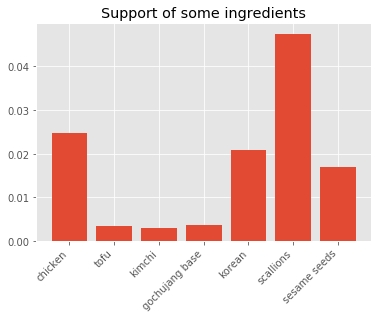

In [309]:
# support of ingredients that I think should be included
my_ingredients = ['chicken','tofu','kimchi', 'gochujang base', 'korean', 'scallions', 'sesame seeds']
plt.bar(my_ingredients, [ing_count[item]/len(ing_list) for item in my_ingredients])
plt.xticks(list(range(len(my_ingredients))), my_ingredients, ha = 'right', rotation=45)
plt.title('Support of some ingredients')
plt.show()

In [310]:
# what are some ingredients with a given support value?
support = 0.001
freq = support * len(ing_list)
ingredients_support = [item for item in ing_by_count if ing_count[item] <= freq + 10 and ing_count[item] >= freq -10 ]
print(ingredients_support[:20])

['organic vegetable broth', 'salad greens', 'file powder', 'rocket leaves', 'ground round', 'cod fillets', 'colby jack cheese', 'pitted date', 'tapioca flour', 'frozen spinach', 'green bell pepper, slice', 'plain whole-milk yogurt', 'duck', 'softened butter', 'low-fat plain yogurt', 'dried tarragon leaves', 'cooked turkey', 'alfredo sauce', 'brewed coffee', 'hot italian sausages']


In [311]:
# LEARNING THE RULES

itemsets, rules = apriori(ing_list, min_support=0.001, min_confidence=0.3)
with open("models/association_rule_mining/rules.txt", "wb") as fp:
    pickle.dump(rules, fp)

## 4.2 Query the rules 

In [312]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [313]:
def get_rules(rules, query):
    # Find all rules of the form "query" => ?

    # query must have the format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    # note that some rules will have multiple items in the right hand side. For simplicity, lets just
    # use rules that return one value 
    query_rules = [item for item in rules if set(item.lhs) == set(query)]

    # sorted ccording to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

In [315]:
query = ('gochujang base',)
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{gochujang base} -> {korean, onions} (conf: 0.338, supp: 0.001, lift: 64.638, conv: 1.503)
{gochujang base} -> {korean, soy sauce} (conf: 0.556, supp: 0.002, lift: 51.822, conv: 2.230)
{gochujang base} -> {korean, sesame oil} (conf: 0.521, supp: 0.002, lift: 51.432, conv: 2.067)
{gochujang base} -> {garlic, korean} (conf: 0.373, supp: 0.001, lift: 48.994, conv: 1.583)
{gochujang base} -> {korean, sesame oil, soy sauce} (conf: 0.345, supp: 0.001, lift: 48.670, conv: 1.516)
{gochujang base} -> {green onions, korean} (conf: 0.352, supp: 0.001, lift: 47.798, conv: 1.532)
{gochujang base} -> {korean} (conf: 0.958, supp: 0.003, lift: 45.896, conv: 23.173)
{gochujang base} -> {sesame oil, soy sauce} (conf: 0.366, supp: 0.001, lift: 12.981, conv: 1.533)
{gochujang base} -> {sesame oil} (conf: 0.542, supp: 0.002, lift: 12.164, conv: 2.087)
{gochujang base} -> {soy sauce} (conf: 0.592, supp: 0.002, lift: 7.138, conv: 2.245)
{gochujang base} -> {green onions} (conf: 0.352, supp: 0.001, lift: 4.55

In [316]:
query = ('chicken','soy sauce')
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{chicken, soy sauce} -> {chinese} (conf: 0.372, supp: 0.001, lift: 5.534, conv: 1.485)
{chicken, soy sauce} -> {garlic} (conf: 0.405, supp: 0.001, lift: 2.182, conv: 1.369)
{chicken, soy sauce} -> {water} (conf: 0.331, supp: 0.001, lift: 1.763, conv: 1.214)
{chicken, soy sauce} -> {salt} (conf: 0.479, supp: 0.001, lift: 1.056, conv: 1.049)


## 4.3 Build a recommendation system

* Input a list of existing ingredients.  
* Recommender searches the learned rules to recommend ingredients, starting with the ingredient with highest lift.  
* If the input list of existing ingredient doesn't exist as an itemset in the learned rules (this happens if the given input does not have enough support in the training dataset), then look for the largest subset of the existing ingredients that do exist as an itemset in the rules. Recommend from this largest subset. 

In [317]:
def get_rules(rules, query, lift_threshold = 1):
    # Find all implication rules of the form "query" => RHS
    # such that (i) RHS is a single ingredient and 
    #           (ii) lift value is greater than lift_threshold

    # "query" format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    query = tuple(query)    
    
    # get all rules "query" => RHS satisfying the conditions above
    query_rules = [item for item in rules if set(item.lhs) == set(query) 
                   if item.lift > lift_threshold and len(item.rhs) == 1]

    # sort rules according to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

def recommend(list_ing, list_old, cuisine, rules):  
    # Recommend ingredients to given list of ingredients.
    # Given a list, attempt to find the largest subset of "n" elements such that
    # the subset leads to a valid ingredient recommendataion. 
    # If such "n" is found, then try recommending ingredients 
    # for all "n"-element subset of list_ing
    
    """
    list_ing: current list of ingredients 
    list_old: List of ingredients (a subset of list_ing) that have previously
            been used to ask for ingredient recommentations. 
            For first round of recommendations, list_old = []
            We keep track of "list_old" so that we don't make duplicate
            recommendations.
    rules: rules learned from apriori algorithm
    """           

    rules_lhs = {item.lhs for item in rules}
    n = len(list_ing)
    current_list = list_ing.copy()
    new_ing = []

    itemset_found = False
    
    while itemset_found == False and n > 0:
        # find all itemsets of size n
        comb = combinations(list_ing, n)

        # check if any itemset of size n satifies the conditions
        # (i) itemset isnt' a subset of list_old  
        # (ii) itemset exists as a left hand side element in rules 
        for itemset in comb:
            if (set(itemset).issubset(set(list_old)) == False) and (itemset in rules_lhs):
 
                # check if the itemset leads to a new ingredient recommendation
                query_rules = get_rules(rules, itemset)
                recommendation = [item.rhs[0] for item in query_rules]
                for ing in recommendation:
                    # if there exists an ingredient that is new and is not a cuisine type
                    # then this itemset just contributed a valid recommendation
                    if (ing not in current_list) and (ing not in cuisine):
                        current_list.append(ing)
                        new_ing.append(ing)            
                        itemset_found = True

        n = n-1           
    return new_ing

def make_recommendations(list_ing, cuisine, rules):
    # Make recommendations by calling the function "recommend" repeatedly.
    # Stop making recommendations when there are a total of 15 ingredients 
    # or when the "recommend" function no longer suggests any recommendations
    # whichever comes first.

    list_old = []
    while len(list_ing) <= 15:
        new_ing = recommend(list_ing, list_old, cuisine, rules)
        list_old = list_ing.copy()
        list_ing += new_ing
        if new_ing == []:
            break
            
    return list_ing

In [318]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [323]:
# ask the recommender for ingredients!
list_ing = ['pork', 'korean']
rules_lhs = {item.lhs for item in rules}
make_recommendations(list_ing, cuisine, rules)

['pork',
 'korean',
 'soy sauce',
 'garlic',
 'onions',
 'salt',
 'sesame oil',
 'green onions',
 'sugar',
 'pepper',
 'olive oil',
 'water',
 'oil']

# 5. Future directions / To Do

* Other models to consider  
    * max entropy model  
    
* To do for building recommender system  
    * Use evaluation metric to find the best model 
    * Or, combine the models using ensemble learning techniques  
    * Create the app  
    * Use Docker containment for production
    